In [1]:
# 1
# Get dataset


import os
import wfdb

# Diretório que contém os arquivos .hea e .dat
diretorio = 'C:/Users/estel/Documents/Python_Codes/set-a/'

# Lista para armazenar os sinais, nomes de arquivo e classes
df_ecg_cinc2011 = []

# Lê os nomes dos pacientes da classe 'positiva' a partir do arquivo .txt
with open(diretorio + 'RECORDS-acceptable', 'r') as file_positivo:
    boa_qualidade = [line.strip() for line in file_positivo]

# Lê os nomes dos pacientes da classe 'negativa' a partir do arquivo .txt
with open(diretorio + 'RECORDS-unacceptable', 'r') as file_negativo:
    ma_qualidade = [line.strip() for line in file_negativo]

# Itera sobre todos os arquivos no diretório
for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.hea'):
        # Extrai o nome do arquivo sem a extensão
        nome_base = os.path.splitext(arquivo)[0]

        # Carrega as informações do cabeçalho (.hea)
        record = wfdb.rdheader(os.path.join(diretorio, nome_base))

        # Carrega os dados do sinal (.dat)
        signals, _ = wfdb.rdsamp(os.path.join(diretorio, nome_base))

        # Determina a classe do paciente
        if nome_base in boa_qualidade:
            classe = 'bom'
        elif nome_base in ma_qualidade:
            classe = 'ruim'
        else:
            classe = 'NaN'

        # Adiciona os sinais, informações adicionais e a classe à lista
        df_ecg_cinc2011.append({'Paciente': nome_base, 'Sinais': signals[:,1], 'Frequencia de Amostragem': record.fs, 'Classe': classe})

In [2]:
# 2
# Indices de qualidade

# Funções para calcular os índices de qualidade
def compute_iSQI(detected_peaks, total_beats):
    return len(detected_peaks) / total_beats * 100

'''def compute_bSQI(detected_peaks_wqrs, detected_peaks_eplimited):
    common_peaks = set(detected_peaks_wqrs).intersection(detected_peaks_eplimited)
    return len(common_peaks) / len(detected_peaks_wqrs) * 100'''

def compute_fSQI(ecg_signal, sampling_rate=1000):
    fn = 0.5 * sampling_rate  # Frequência de Nyquist
    power_5_20Hz = np.sum(np.square(ecg_signal[(5 <= fn) & (fn <= 20)]))
    power_0_fnHz = np.sum(np.square(ecg_signal[fn <= 0.5 * sampling_rate]))
    return power_5_20Hz / power_0_fnHz

def compute_sSQI(ecg_signal):
    return skew(ecg_signal)

def compute_kSQI(ecg_signal):
    return kurtosis(ecg_signal)

def compute_pSQI(ecg_signal, epsilon=1.0):
    dxm_dt = np.gradient(ecg_signal)
    flat_line_percentage = np.sum(np.abs(dxm_dt) < epsilon) / len(ecg_signal) * 100
    return flat_line_percentage

# Plot
def plot_detected_peaks(t, ecg_signal, detected_peaks):
    # Plotar os sinais original e filtrado com os picos QRS detectados
    plt.figure(figsize=(12, 8))
    plt.plot(t, ecg_signal, label='Sinal original', alpha=0.7)
    plt.scatter(t[detected_peaks], ecg_signal[detected_peaks], color='red', marker='o', label='Picos QRS')
    plt.title('Sinal de ECG com Picos R Detectados')
    plt.vlines(t[detected_peaks], *plt.ylim(), label="Picos", color=".2", alpha=0.3, ls="--")
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import skew, kurtosis

from scipy.signal import find_peaks, butter, lfilter
from scipy import signal
import scipy.signal

In [4]:
# Parâmetros
sampling_rate = df_ecg_cinc2011[3]['Frequencia de Amostragem']
duration = 10
t = np.arange(0, duration, 1/sampling_rate)
filename = df_ecg_cinc2011[3]['Paciente']
classe = df_ecg_cinc2011[3]['Classe']

print(f'Filename: {filename}')
print(f'Classe: {classe}')

ecg_signal = df_ecg_cinc2011[3]['Sinais']

# Encontrar picos no sinal bruto
peaks, _ = find_peaks(ecg_signal,height=0.2, distance=sampling_rate / 2)

Filename: 1004502
Classe: ruim


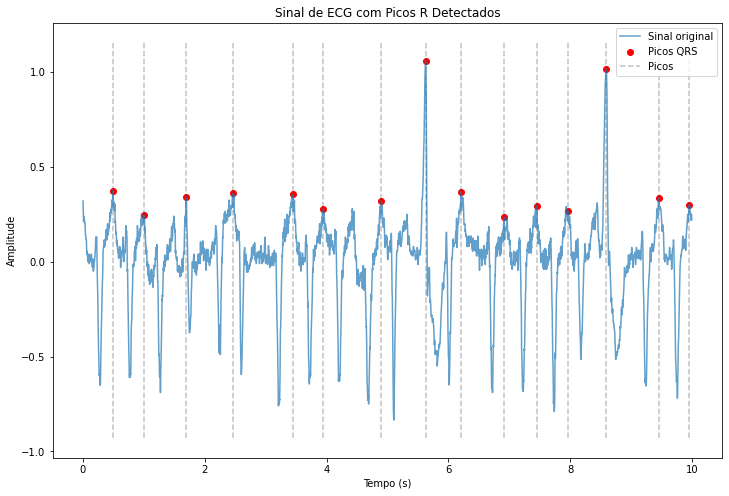

In [5]:
plot_detected_peaks(t, ecg_signal, peaks)

In [6]:
# Calcular índices de qualidade
iSQI_value = compute_iSQI(peaks, len(t))
fSQI_value = compute_fSQI(ecg_signal)
sSQI_value = compute_sSQI(ecg_signal)
kSQI_value = compute_kSQI(ecg_signal)
pSQI_value = compute_pSQI(ecg_signal)

In [7]:
# Imprimir os valores dos índices de qualidade
print(f"iSQI: {iSQI_value}")
print(f"fSQI: {fSQI_value}")
print(f"sSQI: {sSQI_value}")
print(f"kSQI: {kSQI_value}")
print(f"pSQI: {pSQI_value}")

iSQI: 0.3
fSQI: 0.0
sSQI: -0.6684783077838481
kSQI: 2.5350057844554126
pSQI: 100.0
